# 循环神经网络的从零开始实现
## 1 one-hot encode

In [127]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

#numstep -- > window size
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

独热编码

In [128]:
#index : 0 , 2 为 1
F.one_hot(torch.tensor([0,2]),len(vocab))
len(vocab)

28

小批量形状是(批量大小, 时间步数)

In [129]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

# 2 RNN

### 2.1 params init
初始化循环神经网络模型的模型参数

In [130]:
def get_params(vocab_size, num_hiddens, device):
    #经过one-hot过后dim 就等于len(vocab) --- >input
    #output --> 分类的一个类别one-hot 
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    W_xh = normal((num_inputs, num_hiddens))
    #上一个时刻的隐藏变量  --> 下一个时刻的隐藏层变量
    # ht -->  ht+1
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    #隐藏变量到output
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

一个init_rnn_state函数在初始化时返回隐藏状态

In [131]:
def init_rnn_state(batch_size, num_hiddens, device):
    #也可以随机
    #放在tuple,为了模块化，后面的LSTM有两个
    #RNN只有一个
    return (torch.zeros((batch_size, num_hiddens), device=device),)

In [132]:

def rnn(inputs, state, params):
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # input：T,batch,len(vocab)(class):one-hot  --- [5, 2, 28]
    for X in inputs:
        #当前时间步 t 
        # torch.mm(H, W_hh)#H:previous H
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        #batch，len(vocab)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    # output ,当前的隐藏状态H
    #output:batch,len(vocab)(所属class),T个时刻
    #len(output) = T -- 5
    #cat后
    # batch x T,len(vocab),T
    #输出(H,)
    return torch.cat(outputs, dim=0), (H,)

## 2.2 创建一个类来包装这些函数

In [133]:
class RNNModelScratch:  
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device, get_params,
                 init_state, forward_fn):
        #初始化vocab_size,num_hiddens,params,init_state,forward(rnn)
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn
    #forward -- call
    #X:batch,T
    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        #这里就是forward函数
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

检查输出是否具有正确的形状

In [134]:
#print(X.shape[0])
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
#Y:batchxT,len(vocab)
#state:batch,num_hiddens
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

## 2.3 预测
首先定义预测函数来生成用户提供的prefix之后的新字符

In [135]:
# prefix:给一段开头，生成后面
#num_preds:需要预测的词数
def predict_ch8(prefix, num_preds, net, vocab, device):  
    """在`prefix`后面生成新字符。"""
    #初始化state
    # batch：只对一个prefix做预测
    state = net.begin_state(batch_size=1, device=device)
    # prefix[0] --> 提取prefix的第一个词
    # 把第一个词的token映射成vocab的index存入outputs
    outputs = [vocab[prefix[0]]]
    #把outputs的最后一个词（最近预测的词），作为下一个预测的input
    # batch，时间步长 = 1x1
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape(
        (1, 1))
    #需要由prefix第一个词生成后面的词
    for y in prefix[1:]:
        #_：占位符
        #主要是为了获取state
        _, state = net(get_input(), state)
        # 使用 给的prefix 的值，不用预测的，就不用积累误差
        outputs.append(vocab[y])
    #现在开始预测
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        #把最大的index取出来，做成一个标量
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    #最后把预测得到的index转为token
    return ''.join([vocab.idx_to_token[i] for i in outputs])
# 预测后面10个词
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller tlkbtlkbtl'

## 2.4 梯度裁剪(gradient clipping)

In [136]:
def grad_clipping(net, theta):  
    """裁剪梯度。"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    #把所有的参数都拉成一个长向量，再求norm
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            #把所有参数
            param.grad[:] *= theta / norm

定义一个函数来训练只有一个迭代周期的模型

In [137]:

def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练模型一个迭代周期（定义见第8章）。"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)
    for X, Y in train_iter:
        #初始化state
        #None  --> 最开始为None
        # use_random_iter  -->  每个batch之间不是连续的，所以不能用上一个时刻的state 
        if state is None or use_random_iter:
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # 不改变state的值
                #只是清理掉计算图
                # 从当前开始做forward，做backward的的时候就只是计算当前T时间内的梯度
                state.detach_()
            else:
                for s in state:
                    s.detach_()
        # 把时间讯息拉到最前面
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            #控制梯度
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    # Exp(avgCrossEntropy)  --> perplex
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

训练函数支持从零开始或使用高级API实现的循环神经网络模型

In [138]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）。"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device,use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 标记/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

现在我们可以训练循环神经网络模型

困惑度 1.1, 71530.6 标记/秒 cuda:0
time travelleryou can show black io whi n be r trlingss ancanser
travelleryou can show black io whi n be r trlingss ancanser


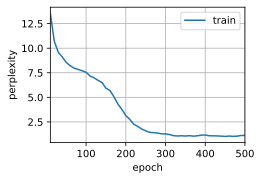

In [139]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

最后，让我们检查一下使用随机抽样方法的结果

困惑度 1.4, 70238.4 标记/秒 cuda:0
time travellerit s against reason said filbywhat oles to the oth
travellerit s against reason said filbywhat oles to the oth


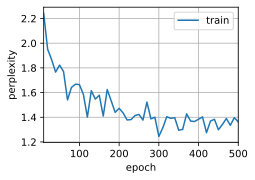

In [140]:
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),use_random_iter=True)